In [1]:
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import (
    calculate_weights,
    get_available_trackers,
    load_trackers,
    get_rebalance_dates,
    cap_long_only_weights,
    calc_covariance,
    cov_to_vols,
)
from backtest import backtest2
from entities import FX_TRACKER_DICT, EM_CDS_TRACKER_DICT

from bwlogger import StyleAdapter, basic_setup
from bwutils import open_file
from portfolio.construction import calculate_weights as calculate_weights_fh

c:\Users\pcampos\anaconda3\envs\bwgi\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
from run_backtest import trackers

trackers

id,BRL_fx,CLP_fx,CNY_fx,COP_fx,CZK_fx,HUF_fx,IDR_fx,INR_fx,MXN_fx,MYR_fx,...,MYR_cds,MXN_cds,PAB_cds,PEN_cds,PHP_cds,QAR_cds,RUB_cds,SAR_cds,ZAR_cds,TRY_cds
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,100.000,100.000,NaN,NaN,100.000,100.000,NaN,NaN,100.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,100.007,100.002,NaN,NaN,99.997,99.958,NaN,NaN,100.041,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-06,100.011,100.026,NaN,NaN,99.973,99.922,NaN,NaN,100.073,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-07,99.939,99.976,NaN,NaN,99.866,99.885,NaN,NaN,99.952,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-08,99.950,100.025,NaN,NaN,99.614,99.756,NaN,NaN,100.095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,291.613,95.636,108.873,146.916,136.539,165.613,258.377,148.422,225.645,193.588,...,114.48,120.88,111.81,114.57,112.70,110.25,NaN,112.94,129.51,131.66
2024-08-27,292.043,95.975,108.980,146.208,136.551,165.317,258.948,148.323,218.886,194.923,...,114.44,120.69,111.88,114.58,112.67,110.35,NaN,113.02,129.61,131.55
2024-08-28,290.494,95.725,108.913,145.456,135.957,164.700,259.096,148.309,220.921,195.220,...,114.45,120.54,111.85,114.54,112.63,110.33,NaN,113.04,129.61,131.43


In [ ]:
columns = trackers.columns
code = pd.Series([col[:3] for col in trackers.columns])
code_unique = code[code.duplicated(keep="first")].to_list()
pairs = [(f"{code}_fx", f"{code}_cds") for code in code_unique]

code = "BRL"
endog = "fx"
exog = "cds"
x = trackers[f"{code}_{exog}"]
y = trackers[f"{code}_{endog}"]
index = x.dropna().index.intersection(y.dropna().index)
x = x.loc[index]
y = y.loc[index]

x

In [14]:
trackers.filter(like="cds", axis=1).dropna(how="all").iloc[252:]

id,AED_cds,ARS_cds,BRL_cds,CNY_cds,CLP_cds,COP_cds,IDR_cds,MYR_cds,MXN_cds,PAB_cds,PEN_cds,PHP_cds,QAR_cds,RUB_cds,SAR_cds,ZAR_cds,TRY_cds
date,,,,,,,,,,,,,,,,,
2008-08-07,NaN,160.52,85.04,NaN,89.82,83.69,NaN,NaN,87.12,84.84,84.19,NaN,90.45,84.98,NaN,82.31,79.30
2008-08-08,NaN,157.86,84.92,NaN,89.79,83.50,NaN,NaN,87.01,84.65,84.01,NaN,90.44,84.46,NaN,82.13,79.01
2008-08-11,NaN,160.17,85.04,NaN,89.82,83.67,NaN,NaN,87.16,84.75,84.13,NaN,90.43,84.47,NaN,82.15,79.23
2008-08-12,NaN,160.61,85.01,NaN,89.84,83.60,NaN,NaN,87.13,84.77,84.10,NaN,90.44,84.64,NaN,82.06,79.32
2008-08-13,NaN,161.95,85.01,NaN,89.84,83.63,NaN,NaN,87.10,84.75,84.10,NaN,90.37,84.48,NaN,81.95,79.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,108.08,47.91,132.29,111.46,111.72,121.57,119.69,114.48,120.88,111.81,114.57,112.70,110.25,NaN,112.94,129.51,131.66
2024-08-27,108.18,48.00,132.25,111.43,111.71,121.52,119.66,114.44,120.69,111.88,114.58,112.67,110.35,NaN,113.02,129.61,131.55
2024-08-28,108.18,48.09,132.20,111.40,111.69,121.39,119.64,114.45,120.54,111.85,114.54,112.63,110.33,NaN,113.04,129.61,131.43


In [4]:
def calculate_alphas_fx_cds_pairs(
    endog: Literal["fx", "cds"], daily_log_returns: pd.DataFrame
) -> pd.Series:
    code = pd.Series([col[:3] for col in daily_log_returns.columns])
    code_unique = code[code.duplicated(keep="first")].to_list()
    pairs = [(f"{code}_fx", f"{code}_cds") for code in code_unique]
    returns = daily_log_returns.rolling(252).sum().iloc[-1]
    cov = calc_covariance(daily_log_returns, "rolling", window=252)
    vols = cov_to_vols(cov)
    betas = pd.Series({(fx, cds): cov.loc[fx, cds] / (vols[cds] ** 2) for fx, cds in pairs})
    alphas = pd.Series(
        {
            idx1: returns[idx1] - returns[idx2] * beta
            for ((idx1, idx2), beta) in betas.iteritems()
        }
    )
    return alphas*(1 if endog == "fx" else -1)


calculate_alphas_fx_cds_pairs("fx", trackers)

C:\Users\pcampos\AppData\Local\Temp\ipykernel_15340\2778739384.py:14: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ((idx1, idx2), beta) in betas.iteritems()


BRL_fx   -0.193882
CNY_fx    0.012818
CLP_fx   -0.094162
COP_fx   -0.047831
IDR_fx   -0.041915
MYR_fx    0.023687
MXN_fx   -0.146953
RUB_fx         NaN
ZAR_fx   -0.079570
TRY_fx    0.081075
dtype: float64

In [17]:
FOLDER = Path("C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests")
list_series = []
for file_path in FOLDER.glob("*.xlsx"):
    s_backtest = pd.read_excel(file_path, index_col=0)["backtest"]
    s_backtest.name = file_path.stem
    list_series.append(s_backtest)
df_backtest = pd.concat(list_series, axis=1)


C:\Users\pcampos\AppData\Local\Temp\ipykernel_15340\4263930402.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(
C:\Users\pcampos\AppData\Local\Temp\ipykernel_15340\4263930402.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(


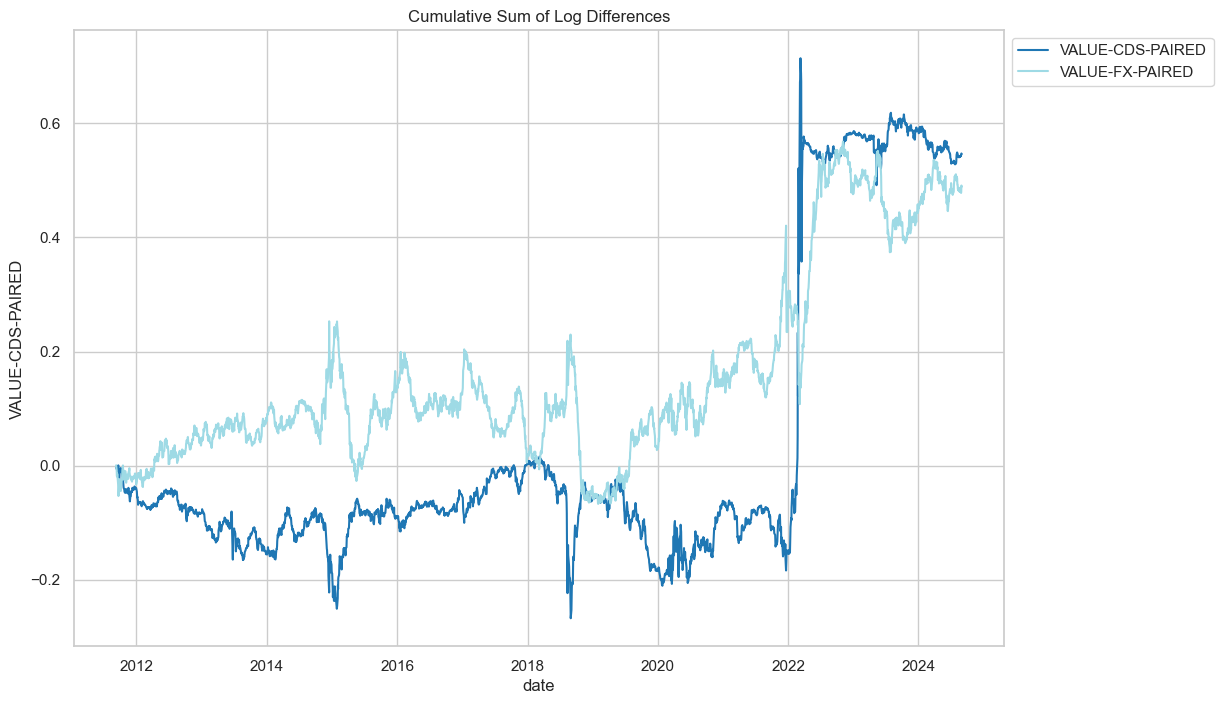

In [19]:
import seaborn as sns
# Assuming df_backtest is already defined
sns.set(style="whitegrid")
data = (
    np.log(df_backtest[["VALUE-CDS-PAIRED", "VALUE-FX-PAIRED"]].dropna(how="any"))
    .diff(1)
    .cumsum()
)
# Create the plot
colors = plt.cm.get_cmap(
    "tab20", len(data.columns)
)  # Get a colormap with enough colors

# Create the plot
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap(
    "tab20", len(data.columns)
)  # Get a colormap with enough colors

for i, column in enumerate(data.columns):
    sns.lineplot(data=data[column], color=colors(i), label=column)

# Add legend and display the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Cumulative Sum of Log Differences")
plt.show()